# Converting Audio into Spectrogram Images and Back

### Install dependencies

In [1]:
!pip install numpy scipy librosa imageio natsort scikit-image -q

## Import dependencies

In [1]:
# Miscellaneous
import os
import glob
import time
from natsort import natsorted

# Scientific
import numpy as np
import scipy
import librosa
from skimage.transform import resize
from beatbrain.metrics import ncc
from beatbrain import utils
import tensorflow as tf

# Visualization
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
from beatbrain.display import show_spec

In [2]:
%matplotlib inline
sns.set()
sns.set_style("white")
plt.rcParams['figure.figsize'] = (10, 5)

## Set up convenience functions

In [3]:
def show_audio(audio, **kwargs):
    ipd.display(ipd.Audio(audio, **kwargs))

## Global constants - change as needed

In [4]:
AUDIO_PATH = "../data/fma/audio/train/000/000005.mp3"
START = 0
DURATION = 5
SAMPLE_RATE = 32768
N_FFT = 4096
HOP_LENGTH = 256
N_MELS = 512
CHUNK_SIZE = 640
RESAMPLE_TYPE = 'kaiser_fast'

## Load some audio

In [5]:
audio, sr = librosa.load(AUDIO_PATH, sr=SAMPLE_RATE,
                         offset=START, duration=DURATION,
                         res_type=RESAMPLE_TYPE)
show_audio(audio, rate=sr)

### Downsample, Upsample

And compute normalized cross-correlation

In [6]:
print(f"NCC @ Original ({sr}Hz):", ncc(audio, audio))
for ratio in [2, 4, 8]:
    downsampled = librosa.resample(audio, sr, sr // ratio)
    upsampled = librosa.resample(downsampled, sr // ratio, sr)
    print(f"NCC @ {sr // ratio}Hz:", ncc(audio, upsampled))
    show_audio(upsampled, rate=sr)

NCC @ Original (32768Hz): 1.0
NCC @ 16384Hz: 0.9973181766000226


NCC @ 8192Hz: 0.9907688166619948


NCC @ 4096Hz: 0.9825846641405029


## (STFT) Spectrogram

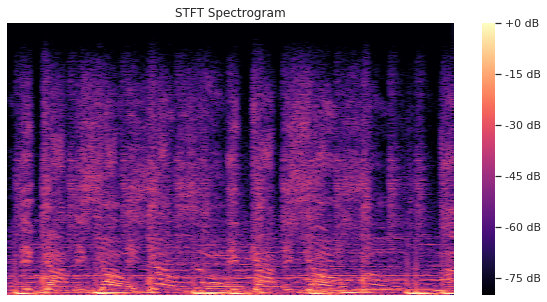

In [7]:
spec = np.abs(librosa.stft(audio, n_fft=N_FFT, hop_length=HOP_LENGTH))
show_spec(spec, scale_fn=librosa.amplitude_to_db, title="STFT Spectrogram")

## Mel Spectrogram

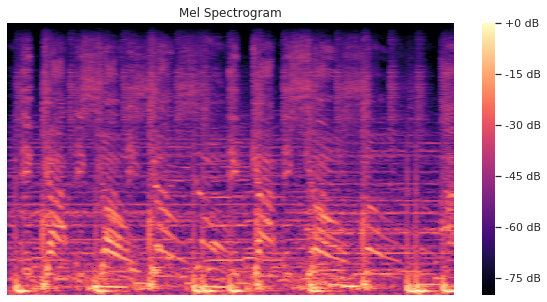

In [8]:
spec = utils.audio_to_spectrogram(audio, sr=sr, n_mels=N_MELS,
                                  n_fft=N_FFT, hop_length=HOP_LENGTH)
show_spec(spec, title="Mel Spectrogram")

## Reconstruct Audio from a Mel Spectrogram

In [32]:
configs = [
    {'n_mels': 512, 'n_fft': 4096, 'hop_length': 256},
    {'n_mels': 256, 'n_fft': 4096, 'hop_length': 256},
    {'n_mels': 128, 'n_fft': 4096, 'hop_length': 256},
]

for config in configs:
    n_fft, hop_length, n_mels = config['n_fft'], config['hop_length'], config['n_mels']
    spec = utils.audio_to_spectrogram(audio, sr=sr,
                                      n_mels=n_mels, n_fft=n_fft,
                                      hop_length=hop_length)
    start = time.time()
    recon = utils.spectrogram_to_audio(spec, sr=sr, n_fft=n_fft, hop_length=hop_length)
    elapsed = time.time() - start
    recon_spec = librosa.feature.melspectrogram(recon, sr=sr, n_mels=N_MELS,
                                                n_fft=N_FFT, hop_length=HOP_LENGTH)
    print(f"Spectrogram shape: {spec.shape}")
    print(f"Reconstructed {len(recon)} samples ({len(recon) / sr:.2f}s)")
    print(f"Audio NCC: {ncc(audio, recon)}")
    print(f"Audio PSNR: {tf.image.psnr(audio[..., None], recon[..., None], 1)}")
    print(f"Spectrogram NCC: {ncc(spec, resize(recon_spec, spec.shape))}")
    print(f"Spectrogram PSNR: {tf.image.psnr(spec[..., None], resize(recon_spec, spec.shape)[..., None], 1)}")
    print(f"Spectrogram SSIM: {tf.image.ssim(tf.convert_to_tensor(spec[..., None]), tf.convert_to_tensor(resize(recon_spec, spec.shape))[..., None], 1)}")
    title = f"FFT {n_fft} | Hop Length {hop_length} | Mels {n_mels} | Time {elapsed:.2f}s"
    show_spec(spec, title=title)
    plt.show()
    show_audio(recon, rate=sr)
    print("=================================================================================")

Spectrogram shape: (512, 641)
Reconstructed 163840 samples (5.00s)
Audio NCC: 0.06721723366250215


InvalidArgumentError: Invalid reduction dimension (-3 for input with 2 dimension(s) [Op:Mean]

#### Convert Audio to Image and back

In [ ]:
import imageio
imageio.plugins.freeimage.download()  # Download EXR library if not present

# Compute and save spectrogram as EXR image
spec = utils.audio_to_spectrogram(audio, sr=sr, n_mels=N_MELS,
                                  n_fft=N_FFT, hop_length=HOP_LENGTH)
show_spec(spec, title="Original")
plt.show()
show_audio(audio, rate=sr)
utils.save_image(utils.normalize_spectrogram(spec), "spec.exr")

# Reconstruct audio from EXR image
spec = utils.load_image("spec.exr")
spec = utils.denormalize_spectrogram(spec)
start = time.time()
recon = utils.spectrogram_to_audio(spec, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
recon_spec = utils.audio_to_spectrogram(recon, sr=sr, n_mels=N_MELS,
                                        n_fft=N_FFT, hop_length=HOP_LENGTH)
print(f"Spectrogram NCC: {ncc(spec, recon_spec)}")
show_spec(recon_spec, title=f"Reconstructed | Time: {time.time() - start}")
plt.show()
print(f"Audio NCC: {ncc(audio, recon)}")
show_audio(recon, rate=sr)